In [1]:
%matplotlib inline

# Standard imports
import copy
import itertools

# Scientific computing imports
import numpy
import matplotlib.pyplot as plt
import networkx as nx
import pandas
from bisect import bisect
import seaborn; seaborn.set()

# Import widget methods
from IPython.html.widgets import *

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
class Ant(object):
    """
    Ant class, which encapsulates the entire behavior of an ant.
    """
    def __init__(self,model,ant_id):
    
        # Set model link and ID
        self.model = model
        self.ant_id = ant_id
        
    def random_walk(self,s,t):
        #Random Walk
        #initialize
        self.source=s
        self.sink=t
        self.g=nx.DiGraph()
        self.last_nodes=[]
        self.last_nodes.append(self.source)


        #Agent Step
        print('looping')
        while self.sink not in self.g:
            for i in xrange(len(self.last_nodes)):
                #get neighbors
                self.base_node=self.last_nodes.pop()
                self.p_neighbors=self.get_neighbors(self.base_node)
                
                #get pheromone of each edge to neighbor
                self.edge_pheromone_list=[]
                for self.potential_node in self.p_neighbors:
                    self.edge_pheromone_list.append(self.get_pheromone_edge((self.base_node,self.potential_node)))
                
                #get next node
                self.next_node=self.p_neighbors[self.make_decision(self.edge_pheromone_list)]
                self.last_nodes.insert(0,self.next_node)
                
                #add edge
                self.g.add_edge(self.base_node,self.next_node)
                #print(self.g.nodes())
                
                #Check termination criteria
                #currently in while loop
                #to be updated to check all sinks.
                

        return (self.g)
    
    def get_neighbors(self,node):
        """
        Return neighbors, calling through model.
        """
        return self.model.get_ant_neighbors(node)
    
    def make_decision(self,pheromone_list):
        """
        Return decision index, based on pheromone list.
        """
        #convert pheromones to percentage
        self.edge_percent_list = [float(i)/sum(pheromone_list) for i in pheromone_list]   
        self.edge_cumulative_percent=numpy.cumsum(self.edge_percent_list)

        #Choose decision index
        self.select_index=bisect(self.edge_cumulative_percent,numpy.random.uniform(0,1,1))
  
        return self.select_index
    
    
    #def get_pheromone_node(self,node):
        """
        Return node pheromone, calling through model.
        """    
    
    
    def get_pheromone_edge(self,edge):
        """
        Return edge pheromone, calling through model.
        """
        return self.model.get_edge_pheromone(edge)
    

    def __repr__(self):
        '''
        Return string representation.
        '''
        skip_none = True
        repr_string = type(self).__name__ + " ["
        except_list = "model"

        elements = [e for e in dir(self) if str(e) not in except_list]
        for e in elements:
            # Make sure we only display "public" fields; skip anything private (_*), that is a method/function, or that is a module.
            if not e.startswith("_") and eval('type(self.{0}).__name__'.format(e)) not in ['DataFrame', 'function', 'method', 'builtin_function_or_method', 'module', 'instancemethod']:
                    value = eval("self." + e)
                    if value != None and skip_none == True:
                        repr_string += "{0}={1}, ".format(e, value)

        # Clean up trailing space and comma.
        return repr_string.strip(" ").strip(",") + "]"

    

In [82]:
class Space(object):
    """
    Space class, which encapsulates the entire behavior of a single "run" ACO.
    """
    def __init__(self, size,num_ants=1,source=(0,0),sink=(3,3)):
        """
        Class constructor.
        """
        # Set our model parameters
        self.size = size
        self.sink = sink
        self.source=source
        self.num_ants=num_ants
        
        # Set our state variables
        self.t = 0
        self.ants = []

        
        # Call our setup methods to initialize space, people, and institution.
        self.setup_space()
        self.setup_ants()
        

    def setup_space(self):
        """
        Method to setup our space.
        """
        # Initialize a space with a grid network
        self.g = nx.grid_graph(dim=[self.size,self.size])
        self.g=self.g.to_directed()
        
        #Set Pheromones
        print('Setting up network')
        for e in self.g.edges_iter():
            self.g.add_edge(e[0],e[1],capacity=0)
            self.g.add_edge(e[0],e[1],edge_pheromone=1)
            self.g.add_edge(e[0],e[1],capacity_pheromone=[(1,1),(2,1)])
            #print(self.g[e[0]][e[1]])

        self.g_layout = nx.spectral_layout(self.g)

        #nx.draw_networkx(self.g, pos=self.g_layout, node_color='#dddddd')
        #print((self.g.number_of_nodes(), self.g.number_of_edges()))

        #plt.show() 
        
    def setup_ants(self):
        """
        Method to setup our space.
        """
        
        # First, begin by creating all ants.
        for i in xrange(self.num_ants):
            self.ants.append(Ant(model=self,ant_id=i))
            
    def get_edge_pheromone(self,edge):
        """
        Get edge decision pheromone for ant call
        """        
        return self.g[edge[0]][edge[1]]['edge_pheromone']
        
        
    def get_ant_neighbors(self,node):
        """
        Get node neighbors for ant call
        """
        return self.g.neighbors(node)
            
    def get_path(self, ant_id):
        """
        Get the path of an ant based on their ID.
        """
        return self.ants[ant_id].random_walk(self.source,self.sink)
    
    def evaluate_graph(self, ant_graph):
        """
        Score graphs based on criteria.
        """
        score=ant_graph.number_of_nodes()
        return score
        
        
    def ant_ranking(self, ant_graphs):
        """
        Find best Ants based on scores from evaluate_graph.
        """
        score_list=[]
        [score_list.append(graph[1]) for graph in ant_graphs]
        print(score_list)
        
        best_ants_index=[]
        [best_ants_index.append(i) for i, j in enumerate(score_list) if j == min(score_list)]
        return best_ants_index
        
    def step(self):
        """
        Model step function.
        """
        #Ants make paths
        self.ant_graphs=[]
        
        #Step for each ant
        for i in xrange(self.num_ants):
            self.ant_graph=self.get_path(i)
            #Evaluate Paths
            self.graph_score=self.evaluate_graph(self.ant_graph)            
            
            #List <graph,score>
            self.ant_graphs.append((self.ant_graph,self.graph_score))
            
        #Get best score
        self.opt_ant=self.ant_ranking(self.ant_graphs)
        print('Best ant',self.opt_ant[0],'Score',self.ant_graphs[self.opt_ant[0]][1])
        
        #Update Institutions
        ##2/24/15

        
                                      

Setting up network


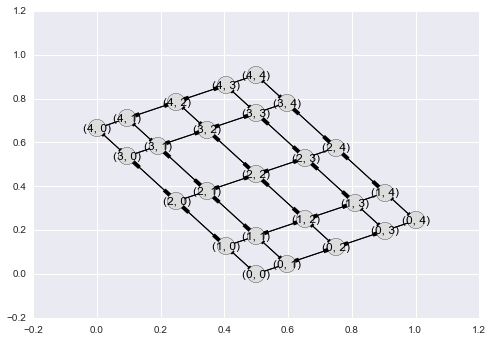

looping
looping
looping
looping
looping
[5, 12, 5, 5, 8]
('Best ant', 0, 'Score', 5)
Ant Path


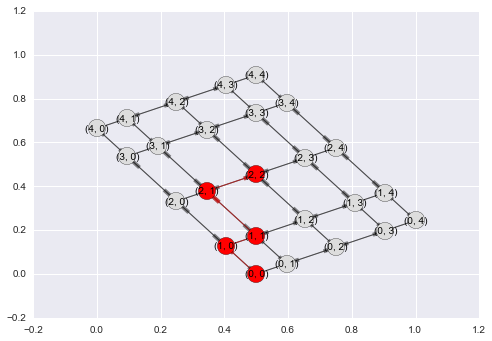

In [87]:
space=Space(size=5,num_ants=5,sink=(2,2))
nx.draw_networkx(space.g, pos=space.g_layout, node_color='#dddddd')
#print((space.g.number_of_nodes(), space.g.number_of_edges()))

plt.show()  

space.step()

print('Ant Path')
#print(space.ant_graphs[0])
#print(space.ant_graphs[0][0].edges())

#p_el=[]

#for i in range(0,len(space.ant_paths[0])-1):
   # p_el.append((space.ant_paths[0][i],space.ant_paths[0][i+1]))
    

# Remove the infected from healthy nodes
nonpath_nodes = [node for node in space.g.nodes() if node not in space.ant_graphs[space.opt_ant[0]][0]]


# Now we can visualize the infected node's position
f = plt.figure()
nx.draw_networkx_nodes(space.ant_graphs[space.opt_ant[0]][0], space.g_layout,
                       node_color='red',edge_color='red')

nx.draw_networkx_nodes(space.g, space.g_layout,
                       nodelist=nonpath_nodes,
                       node_color='#dddddd')

nx.draw_networkx_edges(space.g, space.g_layout, 
                       width=1.0, 
                       alpha=0.5,
                       edge_color='#111111')

nx.draw_networkx_edges(space.ant_graphs[space.opt_ant[0]][0], space.g_layout,
                      edgelist=space.ant_graphs[space.opt_ant[0]][0].edges(),
                      width=1.0, 
                      alpha=0.5,
                      edge_color='red')


_ = nx.draw_networkx_labels(space.g, space.g_layout,
                        dict(zip(space.g.nodes(), space.g.nodes())),
                        font_size=10)

In [25]:
g = nx.grid_graph(dim=[1,2])

g=g.to_directed()

g.add_edge((0,0),(0,1),capacity=0)
g.add_edge((0,0),(0,1),edge_pheromone=1)
g.add_edge((0,0),(0,1),capacity_pheromone=[(1,1),(2,1)])
print(g.nodes())
print(g.edges())
print(g[(0,0)][(0,1)]['capacity'])
g[(0,0)][(0,1)]



[(0, 1), (0, 0)]
[((0, 1), (0, 0)), ((0, 0), (0, 1))]
0


{'capacity': 0, 'capacity_pheromone': [(1, 1), (2, 1)], 'edge_pheromone': 1}

In [63]:
#Pheromone test

l=[.1,.2,.2]
nl=[0]
for i in xrange(len(l)):
    nl.append(l[i]/sum(l))

print(nl)

[0.2, 0.4, 0.4]


In [34]:
from bisect import bisect
g = nx.grid_graph(dim=[2,2])

g=g.to_directed()

for e in g.edges_iter():
    #print(e)
    g.add_edge(e[0],e[1],capacity=0)
    g.add_edge(e[0],e[1],edge_pheromone=1)
    g.add_edge(e[0],e[1],capacity_pheromone=[(1,1),(2,1)])
    #print(g[e[0]][e[1]])

#print(g.nodes())
node=(0,0)
n_neighbors=g.neighbors(node)
#print(n_neighbors)
epl=[]

#Get pheromone for each neighbor edge
for n in n_neighbors:
    #print(n)
    edge=(node,n)
    #print(edge)
    pheromone=g[edge[0]][edge[1]]['edge_pheromone']
    epl.append((edge,pheromone))
    
print(epl)

#convert pheromone to percentage
epherl=[]
for i in xrange(len(epl)):
    epherl.append(epl[i][1])
print(epherl)
    
epercl = [float(i)/sum(epherl) for i in epherl]   
print(epercl)

ecumsum=numpy.cumsum(epercl)
print(ecumsum)

#select node
#random_select=numpy.random.uniform(0,1,1)
#print(random_select)
index=bisect(ecumsum,numpy.random.uniform(0,1,1))
print(index)
next_node=n_neighbors[index]
print(n_neighbors)
print(next_node)
print(node in g)

[(((0, 0), (0, 1)), 1), (((0, 0), (1, 0)), 1)]
[1, 1]
[0.5, 0.5]
[ 0.5  1. ]
1
[(0, 1), (1, 0)]
(1, 0)
True


In [22]:
g=nx.DiGraph()
g.add_edge(1,2)
g.add_edge(1,2)
print(g.edges())

[(1, 2)]


In [10]:
q=[1,2,3,4]
print(q)
while q:
    next_node=q.pop()
    print(next_node)
    
print(q)

[1, 2, 3, 4]
4
3
2
1
[]


In [8]:

G = nx.DiGraph()
G.add_edge('x','a', capacity=3.0)
G.add_edge('x','b', capacity=1.0)
G.add_edge('a','c', capacity=3.0)
G.add_edge('b','c', capacity=5.0)
G.add_edge('b','d', capacity=4.0)
G.add_edge('d','e', capacity=2.0)
G.add_edge('c','y', capacity=2.0)
G.add_edge('e','y', capacity=3.0)
print(G.edges())
F = nx.ford_fulkerson_flow(G, 'x', 'y')
for u, v in G.edges_iter():
     print('(%s, %s) %.2f' % (u, v, F[u][v]))
 

[('a', 'c'), ('c', 'y'), ('b', 'c'), ('b', 'd'), ('e', 'y'), ('d', 'e'), ('x', 'a'), ('x', 'b')]


AttributeError: 'module' object has no attribute 'ford_fulkerson_flow'

In [41]:


my_list=[0,4,2,4,3,0]
max_value = max(my_list)
max_index = my_list.index(max_value)
print(max_index)
ind=my_list.index(max(my_list))
print(ind)

index=[]
[index.append(i) for i, j in enumerate(my_list) if j == max(my_list)]

print(index)


1
1
[1, 3]
